In this we will work on MNIST dataset to train a Deep Neural Network to classify handwritten digit images.

# Loading and Preprocessing Dataset

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
np.random.seed(152)

In [0]:
mnist_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Udacity_DL/Dataset/MNIST-Dataset/Train.csv')
mnist_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Udacity_DL/Dataset/MNIST-Dataset/test.csv')

In [4]:
mnist_train.shape, mnist_test.shape

((42000, 785), (28000, 784))

In [5]:
mnist_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
mnist_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
img = mnist_train[1:2]

type(img), img.shape

(pandas.core.frame.DataFrame, (1, 785))

In [8]:
img = img.drop('label', axis=1)

img = img.values

img.shape

(1, 784)

In [9]:
img = img.reshape(1, 28, 28)

img.shape

(1, 28, 28)

In [10]:
img = img.squeeze()

img.shape

(28, 28)

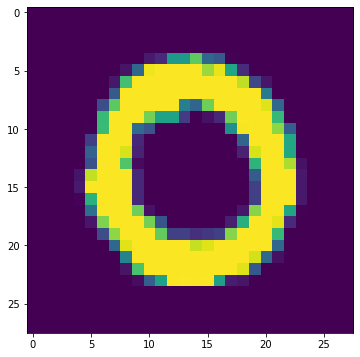

In [11]:
plt.figure(figsize = (6, 6))

plt.imshow(img)

Dropping any record which has missing field

In [0]:
mnist_train = mnist_train.dropna()
mnist_test = mnist_test.dropna()

In [0]:
mnist_train_features = mnist_train.drop('label', axis=1)
mnist_train_target = mnist_train['label']

In [0]:
# mnist_test_features = mnist_test.drop('label', axis=1)
# mnist_test_target = mnist_test['label']

In [15]:
print("train max - ", mnist_train_features.values.max())
print("train min - ", mnist_train_features.values.min())
# print("test max - ", mnist_test.values.max())
# print("test min - ", mnist_test.values.min())

train max -  255
train min -  0


Feature Normalization

In [0]:
mnist_train_features = mnist_train_features.astype('float32')

mnist_train_features = mnist_train_features/255

In [17]:
mnist_train_target

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [0]:
# mnist_test = mnist_test.astype('float32')

# mnist_test = mnist_test/255

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(mnist_train_features, mnist_train_target, test_size=0.2, random_state=0)

In [21]:
X_train.shape, X_val.shape

((33600, 784), (8400, 784))

# Creating Model

In [0]:
import torch.nn as nn
import torch

In [0]:
X_train_tensor = torch.tensor(X_train.values, dtype = torch.float)
X_val_tensor = torch.tensor(X_val.values, dtype = torch.float)
Y_train_tensor = torch.tensor(Y_train.values, dtype = torch.long)
Y_val_tensor = torch.tensor(Y_val.values, dtype = torch.long)

In [0]:
input_size = 784
output_size = 10

hidden_size1 = 16
hidden_size2 = 32

In [0]:
class FccNet1(nn.Module):

  def __init__(self):
    super(FccNet1, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size1)
    self.fc2 = nn.Linear(hidden_size1, hidden_size2)
    self.fc3 = nn.Linear(hidden_size2, output_size)

  def forward(self, x):
    x = torch.sigmoid(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))

    x = self.fc3(x)

    return torch.log_softmax(x, dim=1)    

#Training Model

In [0]:
model = FccNet1()

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [28]:
model.to(device)

FccNet1(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [0]:
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)

Y_train_tensor = Y_train_tensor.to(device)
Y_val_tensor = Y_val_tensor.to(device)

In [0]:
import torch.optim as optim

In [0]:
optimizer = optim.Adam(model.parameters(), lr= 0.001)

loss_fn = nn.NLLLoss()

In [0]:
epochs = 50

In [33]:
for epoch in range(1, epochs+1):

  optimizer.zero_grad()
  Y_pred = model(X_train_tensor)

  loss = loss_fn(Y_pred, Y_train_tensor)
  loss.backward()

  optimizer.step()

  if epoch%10 == 0:
    print("Epoch - ", epoch, ", Loss - ", loss.item())

Epoch -  10 , Loss -  2.315797805786133
Epoch -  20 , Loss -  2.2845566272735596
Epoch -  30 , Loss -  2.2641212940216064
Epoch -  40 , Loss -  2.2438173294067383
Epoch -  50 , Loss -  2.2198734283447266


In [34]:
model.eval()
#to make sure that things like dropout which are only required at training are closed

FccNet1(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [36]:
with torch.no_grad():

  correct = 0
  total = 0

  outputs = model(X_val_tensor)
  _, predicted = torch.max(outputs.data, 1)

  y_val = Y_val_tensor.cpu().numpy()
  predicted = predicted.cpu()

  print("Accuracy: ", accuracy_score(predicted, y_val))
  print("Precision: ", precision_score(predicted, y_val, average="weighted"))
  print("Recall: ", recall_score(predicted, y_val, average="weighted"))

Accuracy:  0.34226190476190477
Precision:  0.8909954375855791
Recall:  0.34226190476190477


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
import torch.nn.functional as F

#Experimenting


In [0]:
input_size = 784
output_size = 10

hidden_size1 = 64
hidden_size2 = 128
hidden_size3 = 256
hidden_size4 = 64

In [0]:
class FccNet2(nn.Module):

  def __init__(self):
    super(FccNet2, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size1)
    self.fc2 = nn.Linear(hidden_size1, hidden_size2)
    self.fc3 = nn.Linear(hidden_size2, hidden_size3)
    self.fc4 = nn.Linear(hidden_size3, hidden_size4)
    self.fc5 = nn.Linear(hidden_size4, output_size)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))

    x = self.fc5(x)

    return torch.log_softmax(x, dim=1)    

In [0]:
model = FccNet2()
model = model.to(device)

In [0]:
optimizer = optim.Adam(model.parameters(), lr= 0.01)

loss_fn = nn.NLLLoss()

In [0]:
epochs = 240

In [164]:
for epoch in range(1, epochs+1):

  optimizer.zero_grad()
  Y_pred = model(X_train_tensor)

  loss = loss_fn(Y_pred, Y_train_tensor)
  loss.backward()

  optimizer.step()

  with torch.no_grad():
    if epoch%10 == 0:
      _, y_pred = torch.max(Y_pred.data, 1)
      y_pred = y_pred.to("cpu")
      y_train = Y_train_tensor.to("cpu").numpy()
      print("Epoch - ", epoch, ", Loss - ", loss.item(), accuracy_score(y_train, y_pred))

Epoch -  10 , Loss -  1.390627145767212 0.47714285714285715
Epoch -  20 , Loss -  0.6697377562522888 0.7825
Epoch -  30 , Loss -  0.4054776132106781 0.8797916666666666
Epoch -  40 , Loss -  0.2962140440940857 0.9135119047619048
Epoch -  50 , Loss -  0.23722979426383972 0.9298511904761905
Epoch -  60 , Loss -  0.1974165141582489 0.9413095238095238
Epoch -  70 , Loss -  0.16750459372997284 0.9508928571428571
Epoch -  80 , Loss -  0.1502658724784851 0.9558333333333333
Epoch -  90 , Loss -  0.12975631654262543 0.960952380952381
Epoch -  100 , Loss -  0.11692285537719727 0.9641666666666666
Epoch -  110 , Loss -  0.10565391182899475 0.9675595238095238
Epoch -  120 , Loss -  0.09786699712276459 0.9703273809523809
Epoch -  130 , Loss -  0.09311895817518234 0.971279761904762
Epoch -  140 , Loss -  0.08314424753189087 0.9734226190476191
Epoch -  150 , Loss -  0.07931559532880783 0.9761607142857143
Epoch -  160 , Loss -  0.06936953216791153 0.9781547619047619
Epoch -  170 , Loss -  0.067359492182

In [165]:
model.eval()
#to make sure that things like dropout which are only required at training are closed

FccNet2(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [166]:
with torch.no_grad():

  correct = 0
  total = 0

  outputs = model(X_val_tensor)
  _, predicted = torch.max(outputs.data, 1)

  y_val = Y_val_tensor.cpu().numpy()
  predicted = predicted.cpu()

  print("Accuracy: ", accuracy_score(predicted, y_val))
  print("Precision: ", precision_score(predicted, y_val, average="weighted"))
  print("Recall: ", recall_score(predicted, y_val, average="weighted"))

Accuracy:  0.9607142857142857
Precision:  0.9609819294066821
Recall:  0.9607142857142857
